In [ ]:
from database import engine, Meta, Session
from sqlmodel import select

import pandas as pd

def get_meta(**kwargs):
    with Session(engine) as session:
        records = session.query(Meta).all()
        df = pd.DataFrame(records, columns=records[0].keys())

        return df


# query = select(Meta)
# with engine.connect() as conn:

#     data = pd.read_sql_query(query, conn)
    
# data

get_meta()

In [ ]:
import asyncio
import yfinance as yf


async def multiply(ticker):
    return yf.download(ticker)

async def main():
    coroutines = []

    for ticker in ["SPY", "AGG"]:
        coro = multiply(ticker)
        coroutines.append(coro)

    results = await asyncio.gather(*coroutines)
    print(results)

asyncio.run(main())


In [ ]:
from src.core.signals import OECDUSLEIHP
import yfinance as yf

prices = yf.download("SPY, AGG")["Adj Close"]
sig = OECDUSLEIHP.from_fred_data()
sig.expected_returns_by_states(prices=prices, frequency="M")

In [ ]:
from src.core.portfolios import Optimizer
import yfinance as yf
import pandas as pd
from typing import Optional, Callable
from functools import partial
from src.core.strategies import Strategy

def backtest(**btkwargs) -> Callable:
    """strategy wrapper"""
    def decorator(func: Callable):
        def wrapper(
            prices: Optional[pd.DataFrame] = None,
            start: Optional[str] = None,
            end: Optional[str] = None,
            frequency: str = "M",
            **kwargs
        ):
            if prices is None:
                prices=btkwargs.get("prices")
            if not isinstance(prices, pd.DataFrame):
                return
            return Strategy(
                prices=prices,
                rebalance=partial(func, **kwargs),
                start=start,
                end=end,
                frequency=frequency,
            )
        return wrapper
    return decorator

@backtest(prices=yf.download("ACWI, BND, GLD, VNQI, SPY, QQQ")["Adj Close"])
def EW(strategy):
    """equal"""
    return Optimizer.from_prices(prices=strategy.reb_prices).uniform_allocation()


EW(start="2022-1-1").value.plot()

In [ ]:
"""ROBERT"""

from src.core.strategies.ext import TargetVol
import yfinance as yf
prices = yf.download("ACWI, BND, GLD, VNQI, SPY, QQQ")["Adj Close"]
strategy = TargetVol(prices=prices, start="2020-1-1", target_vol=0.25)
strategy.value.plot()

In [ ]:
import pandas as pd


data = pd.read_clipboard()

data

In [ ]:

import yfinance as yf
prices = yf.download("SPY, QQQ, XLU, XLY")["Adj Close"].dropna().loc["2008":]
t = TargetVol(prices=prices)
t.value.plot()

In [ ]:
t.value.loc["2015":].plot()

In [ ]:
import yfinance as yf

p = yf.download("TLT", actions=True)

p[["Dividends"]].plot()

In [ ]:
p = yf.download("XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY")['Adj Close']
from app.core.analytics.metrics import to_start


to_start(p).to_clipboard()

In [ ]:
dividends = p[["Dividends"]]
dividends = dividends[dividends["Dividends"] != 0]
dividends

In [ ]:
p.Close.loc["2023-4-28":].pct_change()

In [ ]:
p["Adj Close"].loc["2023-4-28":]

In [ ]:
p["Close"].loc["2023-4-28":] - p["Dividends"].loc["2023-4-28":].shift(-1).bfill()

In [ ]:
from app.core.analytics import metrics
def analytics() -> pd.DataFrame:
    """analytics"""
    
    __metrics__ = [
        metrics.to_ann_return,
        metrics.to_ann_volatility,
        metrics.to_sharpe_ratio,
        metrics.to_skewness,
        metrics.to_kurtosis,
        metrics.to_value_at_risk,
        metrics.to_conditional_value_at_risk,
    ]
    
    result = [metric(strategy.value.to_frame()).to_frame() for metric in __metrics__]
    print(pd.concat(result, axis=1).round(4))

analytics()

In [ ]:
import sqlalchemy as sa
from sqlalchemy.ext.declarative import declarative_base

Base = declarative_base()

class Meta(Base):
    __tablename__ = "tb_meta"
    
    id = sa.Column(sa.Integer, primary_key=True, autoincrement=True)
    ticker = sa.Column(sa.String, index=True)
    name = sa.Column(sa.String)
    source = sa.Column(sa.String)
    category = sa.Column(sa.String)
    
    
    
    

In [ ]:
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
import sqlalchemy as sa

class Meta(Base):
    """
    Represents a metadata record in the database.
    """

    __tablename__ = "tb_meta"
    __table_args__ = (sa.UniqueConstraint("code", "name", name="uc_code_name"),)
    id = sa.Column(
        sa.Integer,
        primary_key=True,
        comment="Internal MetaID",
        doc="Internal Meta ID (UNIVERSAL)",
    )
    code = sa.Column(
        sa.VARCHAR(100),
        unique=True,
        nullable=False,
        index=True,
        comment="Code that could be recognized by Users.",
        doc="Code for user interface",
    )
    category = sa.Column(
        sa.VARCHAR(20),
        nullable=True,
        unique=False,
        comment="Metadata Type",
        doc="Metadata Type",
    )
    instrument = sa.Column(
        sa.VARCHAR(20),
        nullable=True,
        unique=False,
        comment="Metadata Instrument",
        doc="Metadata Instrument",
    )
    isin = sa.Column(
        sa.CHAR(12),
        nullable=True,
        comment="International Securities Identification Code (12)",
        doc="International Securities Identification Code (12)",
    )
    name = sa.Column(
        sa.VARCHAR(255),
        nullable=False,
        unique=True,
        comment="Abbreviated Name",
        doc="Short Name",
    )
    description = sa.Column(
        sa.VARCHAR(1000),
        unique=False,
        nullable=True,
        comment="Description for the Meta",
        doc="Description for the Meta",
    )
    deactive = sa.Column(
        sa.Boolean,
        nullable=False,
        # Use a SQLAlchemy text clause for default value
        default=sa.text("false"),
        server_default=sa.text("false"),
    )
    source = sa.Column(sa.VARCHAR(255), nullable=True, comment="source", doc="source")
    yahoo = sa.Column(
        sa.VARCHAR(100),
        nullable=True,
        comment="Code that could be recognized by Yahoo.",
        doc="Code for Yahoo",
    )
    naver = sa.Column(
        sa.VARCHAR(100),
        nullable=True,
        comment="Code that could be recognized by Naver.",
        doc="Code for Naver.",
    )
    bloomberg = sa.Column(
        sa.VARCHAR(100),
        nullable=True,
        comment="Code that could be recognized by Naver.",
        doc="Code for Naver.",
    )
    morningstar = sa.Column(
        sa.VARCHAR(100),
        nullable=True,
        comment="Code that could be recognized by Morningstar.",
        doc="Code for Morningstar.",
    )
    reuters = sa.Column(
        sa.VARCHAR(100),
        nullable=True,
        comment="Code that could be recognized by Reuters.",
        doc="Code for Reuters.",
    )    

[*********************100%***********************]  11 of 11 completed


<AxesSubplot:>

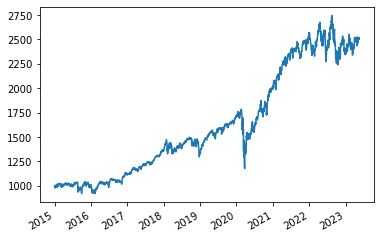

In [20]:
from core.signals import OECDUSLEIHP
from core.portfolios import Optimizer
from core.strategies import backtest
import pandas as pd
import yfinance as yf


@backtest
def SectorRotation(strategy, signal):

    state = signal.get_state(str(strategy.date))
    exp_ret = signal.expected_returns_by_states(
        strategy.reb_prices.iloc[-252 * 5 :]
    ).dropna(how="all", axis=1)
    index = exp_ret.loc[state].nlargest(5).index
    prices = strategy.reb_prices[index].dropna(axis=1, how="all")
    allocations = Optimizer.from_prices(prices=prices).uniform_allocation()
    return allocations


prices = yf.download(tickers="XLC, XLY, XLP, XLE, XLF, XLV, XLI, XLB, XLRE, XLK, XLU")[
    "Adj Close"
]
signal = OECDUSLEIHP.from_fred_data()

strategy = SectorRotation(prices=prices, signal=signal, start="2015-1-1")
strategy.value.plot()


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

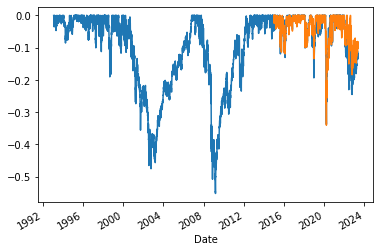

In [21]:
from core.analytics import metrics
metrics.to_drawdown(yf.download("SPY")["Adj Close"]).plot()
metrics.to_drawdown(strategy.value).plot()

In [ ]:

exp_ret = signal.expected_returns_by_states(prices)

In [10]:
exp_ret.loc["expansion"].sort_values()

XLP     0.005696
XLU     0.006476
XLF     0.007542
XLY     0.011492
XLV     0.011741
XLE     0.013406
XLB     0.013701
XLI     0.013982
XLK     0.017811
XLRE    0.020875
XLC     0.031085
Name: expansion, dtype: float64

In [ ]:
from src import database
import pandas as pd
from src import config

# database.client.conn.create_all()
database.UniverseMeta.insert(
    pd.read_clipboard()
)


In [ ]:
from app import database as db

# with db.engine.connect() as conn:
#     conn.execute(
#         f"CREATE VIEW tb_test AS SELECT * FROM tb_meta WHERE tb_meta.meta_type == 'Equity'"
#     )


with db.SessionContext() as session:
    
    result = session.execute("SELECT * FROM tb_test")
    
    print(result.fetchall())


In [ ]:
from app.core.strategies import HierarchicalEqualRiskContribution
import yfinance as yf

prices = yf.download("SPY, QQQ, XLG, XLV, XLU, XLB")["Adj Close"]

strategy = HierarchicalEqualRiskContribution(prices=prices.dropna()).simulate("2023-1-1")

strategy.value.plot()

In [ ]:
from typing import Optional
import pandas as pd
from app.core.strategies import Strategy
from app.core.analytics.features import momentum
from app.core.analytics.metrics import to_ann_volatility


class DualMomentum(Strategy):
    # Objective: balanced growth
    # Type: momentum strategy
    # Invests in: ETFs tracking stocks, bonds, real estate, and gold
    # Rebalancing schedule: monthly
    # Taxation: 50% short-term capital gains
    # Minimum account size: $5,000
    def rebalance(self) -> Optional[pd.Series]:
        single_weight = 1 / (len(self.reb_prices.columns) - 1)
        safe = to_ann_volatility(self.reb_prices.iloc[-252:]).idxmin()
        mome_1y = momentum(self.reb_prices, months=6).iloc[-1]
        safe_mome = mome_1y.loc[safe]
        weights = {}
        for asset in self.reb_prices:
            if asset == safe:
                continue
            if mome_1y.loc[asset] > safe_mome:
                weights.update({asset: single_weight})
            else:
                if safe in weights.keys():
                    weights.update({safe: weights[safe] + single_weight})
                else:
                    weights.update({safe: single_weight})
        return pd.Series(weights)


import yfinance as yf

prices = yf.download("SPY, VNQ, XLK, XLU, XLB, XLV, XLY, XLG, BIL, AGG, TLT")["Adj Close"]

strategy = DualMomentum(prices=prices).simulate("2015-1-1")

strategy.value.plot()


In [ ]:
from app.core.portfolios import Optimizer
from app.core.strategies import Strategy

class MaxSharpe(Strategy):
    def rebalance(self):
        prices = self.reb_prices.iloc[-252:]
        opt = Optimizer.from_prices(prices)
        return opt.maximized_sharpe_ratio()

import yfinance as yf

prices = yf.download("SPY, VNQ, XLK, XLU, XLB, XLV, XLY, XLG, BIL, AGG, TLT")["Adj Close"]

prices

In [ ]:
test = prices.copy()
test[~test.isnull()] = 1
test


In [ ]:
from app.core.strategies import HierarchicalEqualRiskContribution
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]

strategy = HierarchicalEqualRiskContribution(prices=prices.dropna()).simulate()

strategy.value


In [ ]:
from src import database as db

with db.SessionContext() as session:

    for (source,) in session.query(db.models.Meta.source).distinct():

        print(source)
        if source == "YAHOO":
            import yfinance as yf
            for meta in (
                session.query(db.models.Meta).filter(db.models.Meta.source == source).all()
            ):
                data = yf.download(
                    tickers=meta.code, start="1980-1-1", progress=False, actions=True
                ).reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = (
                        data.dividends.divide(data.close.shift(1)).fillna(0)
                    )
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)

        elif source == "NAVER":
            import pandas_datareader as pdr
            for meta in (
                session.query(db.models.Meta).filter(db.models.Meta.source == source).all()
            ):
                data = pdr.DataReader(name=meta.code, data_source="naver", start="1980-1-1").astype(float)
                data = data.reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = (
                        data.dividends.divide(data.close.shift(1)).fillna(0)
                    )
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)
        else:
            data = None
        



In [ ]:
import pandas as pd

w = pd.read_clipboard(index_col="date")
r = w.stack().astype(float)
r = r.reset_index()
r.columns = ["date", "ticker", "weight"]
r = r[r.weight != 0.0]
r.to_clipboard()

In [ ]:
pd.to_datetime(pd.to_datetime("2022-2-1")).to_pydatetime()

In [ ]:
pd.read_excel(
    config.DATABASE_EXC, 
    sheet_name="tb_meta", 
    parse_dates=["inception_date"]
).sort_values("meta_id")

In [ ]:
import pandas_datareader as pdr
import pandas as pd
def leading_economic_indicator() -> pd.DataFrame:
    """
    Get raw data for leading economic indicator regime.
    """
    tickers = dict(USALOLITONOSTSAM="USLEI")
    data = pdr.DataReader(list(tickers.keys()), "fred", start="1900-01-01").resample("M").last()
    data = data.rename(columns=tickers)
    return data[['USLEI']]

leading_economic_indicator()

In [ ]:
from src.core import metrics


import pandas as pd
nav = pd.read_clipboard(index_col="date", parse_dates=True)
nav

In [ ]:
metrics.to_max_drawdown(nav).to_clipboard()

In [ ]:
(prices / prices.resample("D").last().ffill().shift(1, freq=pd.DateOffset(months=1))).dropna()


In [ ]:
prices.pct_change(21)

In [ ]:
import pandas as pd

pri_returns = prices.pct_change()
latest_date = pri_returns.index[-1]
start_date = latest_date + pd.DateOffset(years=5)
start_date

In [ ]:
from src import db


db.create_all()

In [ ]:
import pandas as pd

pr_date = prices.index[-1] - pd.DateOffset(years = 1)

prices.iloc[-1] / prices.iloc[prices.index.get_loc(pr_date)] - 1

In [ ]:
import pandas_datareader as pdr



price = pdr.DataReader("329200", "naver", start="2021-4-1")
price.to_csv("329200.csv")

In [ ]:
import json

import pandas as pd
from sec_api import QueryApi
from sec_api import ExtractorApi
from src.config import EDGAR_API

queryApi = QueryApi(api_key=EDGAR_API)

query = {
    "query": {
        "query_string": {
            "query": "ticker:TSLA",
        }
    },
    "from": "200",
    "size": "300",
    "sort": [{"filedAt": {"order": "desc"}}],
}

response = queryApi.get_filings(query)


metadata = pd.DataFrame.from_records(response["filings"])

print(metadata)


# extractorApi = ExtractorApi(EDGAR_API)


# sections_10_k = {
#     "1": "Business",
#     "1A": "Risk Factors",
#     "1B": "Unresolved Staff Comments",
#     "2": "Properties",
#     "3": "Legal Proceedings",
#     "4": "Mine Safety Disclosures",
#     "5": "Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities",
#     "6": "Selected Financial Data (prior to February 2021)",
#     "7": "Management’s Discussion and Analysis of Financial Condition and Results of Operations",
#     "7A": "Quantitative and Qualitative Disclosures about Market Risk",
#     "8": "Financial Statements and Supplementary Data",
#     "9": "Changes in and Disagreements with Accountants on Accounting and Financial Disclosure",
#     "9A": "Controls and Procedures",
#     "9B": "Other Information",
#     "10": "Directors, Executive Officers and Corporate Governance",
#     "11": "Executive Compensation",
#     "12": "Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters",
#     "13": "Certain Relationships and Related Transactions, and Director Independence",
#     "14": "Principal Accountant Fees and Services",
# }


# for id, f in enumerate(response["filings"]):
#     if f["formType"] == "10-K":
#         url_10k = f["linkToFilingDetails"]

#         out = {}

#         for sec, des in sections_10_k.items():
#             out[des] = extractorApi.get_section(url_10k, sec, "text")

#         filename = f"{id}.json"

#         with open(filename, "w") as f:
#             json.dump(out, f)


In [ ]:
metadata.to_csv(
    'test.csv'
)

In [ ]:
response['filings'][0]['linkToTxt']

In [ ]:


# 8-K example
url_8k = "https://www.sec.gov/Archives/edgar/data/66600/000149315222016468/form8-k.htm"

item_1_1_text = extractorApi.get_section(response['filings'][0]['linkToTxt'], "1-1", "text")
item_1_1_text

In [ ]:


stra = strategy.HierarchicalEqualRiskContribution(prices=prices).simulate(
    start="2015-1-1"
)
stra.value.plot()
# weights_bm = prices.notna().divide(prices.notna().sum(axis=1), axis=0)
# metrics.to_pri_return(prices=prices).multiply(weights_bm).sum(axis=1).loc["2015-1-1":].add(1).cumprod().multiply(1000).plot()
stra.analytics()

In [ ]:
from src import db


with db.SessionContext() as session:
    
    query = session.query(db.models.Meta)
    
    result = list(record.to_dict() for record in query.all())
    
print(result)

In [ ]:
import pandas as pd

pd.DataFrame(result)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create line chart trace
line_trace = go.Scatter(
    x=stra.value.index, y=stra.value.values, mode="lines", name=stra.value.name
)

# create stacked bar chart traces
bar_traces = []
for col in stra.allocations.columns:
    trace = go.Bar(x=stra.allocations.index, y=stra.allocations[col]*100, name=col)
    bar_traces.append(trace)

# create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# add line chart to the first subplot with its own legend
fig.add_trace(line_trace, row=1, col=1)
fig.update_traces(showlegend=True, row=1, col=1)

# add stacked bar chart to the second subplot with its own legend
for trace in bar_traces:
    fig.add_trace(trace, row=2, col=1)
    fig.update_traces(showlegend=True, row=2, col=1)

# update chart layout and style
fig.update_layout(
    title="My Beautiful Subplots",
    xaxis_title="Date",
    yaxis_title="Values",
    template="plotly_dark",
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        x=0.5,
        y=1.2,
        orientation='h',
        xanchor='center',
        yanchor='bottom',
        bordercolor="white",
        borderwidth=1,
        bgcolor="white",
        font=dict(size=12),
    ),
    font=dict(family="Arial", size=12, color="black"),
    barmode="stack",
    # add legends for subplots
    annotations=[
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Line Chart</b>",
            font=dict(size=14),
            align="center",
        ),
        dict(
            x=0.5,
            y=0.6,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Stacked Bar Chart</b>",
            font=dict(size=14),
            align="center",
        ),
    ],
)

# show the chart
fig.show()


In [ ]:
from src.core.portfolios import Optimizer
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]
opt = Optimizer.from_prices(prices=prices)
opt.hierarchical_equal_risk_contribution()

In [ ]:
opt.hierarchical_risk_parity()

In [ ]:
opt.maximized_sharpe_ratio()